<a href="https://colab.research.google.com/github/KamilShape/emotion_recognition/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introduction**

In [1]:
#Libraries
import os
import cv2
from google.colab.patches import cv2_imshow
import shutil
#----------------visualisation---------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#----------------keras-----------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
#---------------PIL--------------------------
from PIL import Image

In [2]:
data_path = 'drive/MyDrive/faces/data'

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


*Dataset is quite balanced.*

# **2. Train and test set**

In [4]:
train_path = 'drive/MyDrive/recognized_faces/train'

In [5]:
test_path = 'drive/MyDrive/recognized_faces/test'

In [6]:
faces_path = 'drive/MyDrive/recognized_faces'

In [7]:
faces_folder = os.listdir('drive/MyDrive/recognized_faces')

In [8]:
faces = ['happiness', 'sadness', 'anger' ]

In [9]:
amount = []

for k in faces:
  amount.append(len(os.listdir(f'drive/MyDrive/recognized_faces/{k}')))

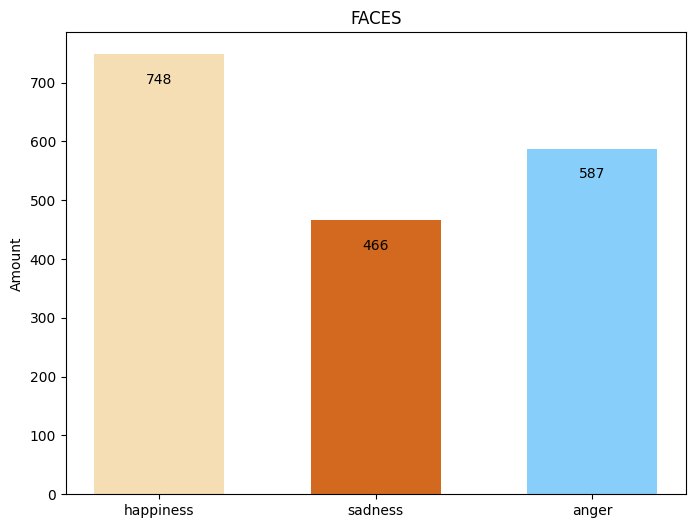

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
colors = ['wheat', 'chocolate', 'lightskyblue','teal', 'gold']
ax.bar(faces, amount, color=colors, width=0.6)
ax.set_title('FACES')
ax.set_ylabel('Amount')

for i in range(0, len(faces)):
  ax.text(faces[i], amount[i] - 50, horizontalalignment='center', s=amount[i] )

In [10]:
def create_set(faces, path, new_path, set_size):
  for face in faces:
    files_folder = os.listdir(f'{path}/{face}')
    for n in range(0, round(len(files_folder)*set_size)):
      files_folder = os.listdir(f'{path}/{face}')
      photo_number = np.random.randint(len(files_folder))
      os.makedirs(f'{new_path}/{face}', exist_ok=True)
      os.replace(f'{path}/{face}/{files_folder[photo_number]}', f'{new_path}/{face}/{files_folder[photo_number]}')

In [ ]:
#creating train set
create_set(faces, faces_path, train_path, 0.8)

In [ ]:
#creating test set
create_set(faces, faces_path, test_path, 1)

In [10]:
img_height = 128
img_width = 128
batch_size = 100

In [11]:
train_ds = keras.utils.image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    seed=0,
    subset='training',
    image_size = (img_height, img_width),
    batch_size = batch_size,
    label_mode = 'categorical')

val_ds = keras.utils.image_dataset_from_directory(
    train_path,
    validation_split = 0.3,
    seed=0,
    subset='validation',
    image_size = (img_height, img_width),
    batch_size = batch_size,
    label_mode = 'categorical')

Found 1441 files belonging to 3 classes.
Using 1153 files for training.
Found 1441 files belonging to 3 classes.
Using 432 files for validation.


# **3. Model**

In [12]:
model = Sequential()
model.add(layers.Rescaling(1./255))

model.add(layers.Conv2D(128, (1,1), padding='same', activation='relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(64, (1,1), padding='same', activation='relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))

In [13]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [15]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 30,
    batch_size = batch_size)

Epoch 1/30
12/12 [==============================] - 121s 11s/step - loss: 1.5453 - accuracy: 0.3469 - val_loss: 1.2059 - val_accuracy: 0.4097
Epoch 2/30
12/12 [==============================] - 4s 223ms/step - loss: 1.1026 - accuracy: 0.4102 - val_loss: 1.0875 - val_accuracy: 0.3727
Epoch 3/30
12/12 [==============================] - 3s 147ms/step - loss: 1.0550 - accuracy: 0.4692 - val_loss: 1.0415 - val_accuracy: 0.4491
Epoch 4/30
12/12 [==============================] - 3s 149ms/step - loss: 0.9874 - accuracy: 0.5221 - val_loss: 0.9698 - val_accuracy: 0.5671
Epoch 5/30
12/12 [==============================] - 3s 145ms/step - loss: 0.8982 - accuracy: 0.5950 - val_loss: 0.8977 - val_accuracy: 0.5995
Epoch 6/30
12/12 [==============================] - 3s 150ms/step - loss: 0.8059 - accuracy: 0.6453 - val_loss: 0.8894 - val_accuracy: 0.6181
Epoch 7/30
12/12 [==============================] - 3s 187ms/step - loss: 0.7354 - accuracy: 0.7060 - val_loss: 0.7738 - val_accuracy: 0.6644
Epoch 

# **4.Learning curve**

In [19]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
array = np.arange(1,31,1)

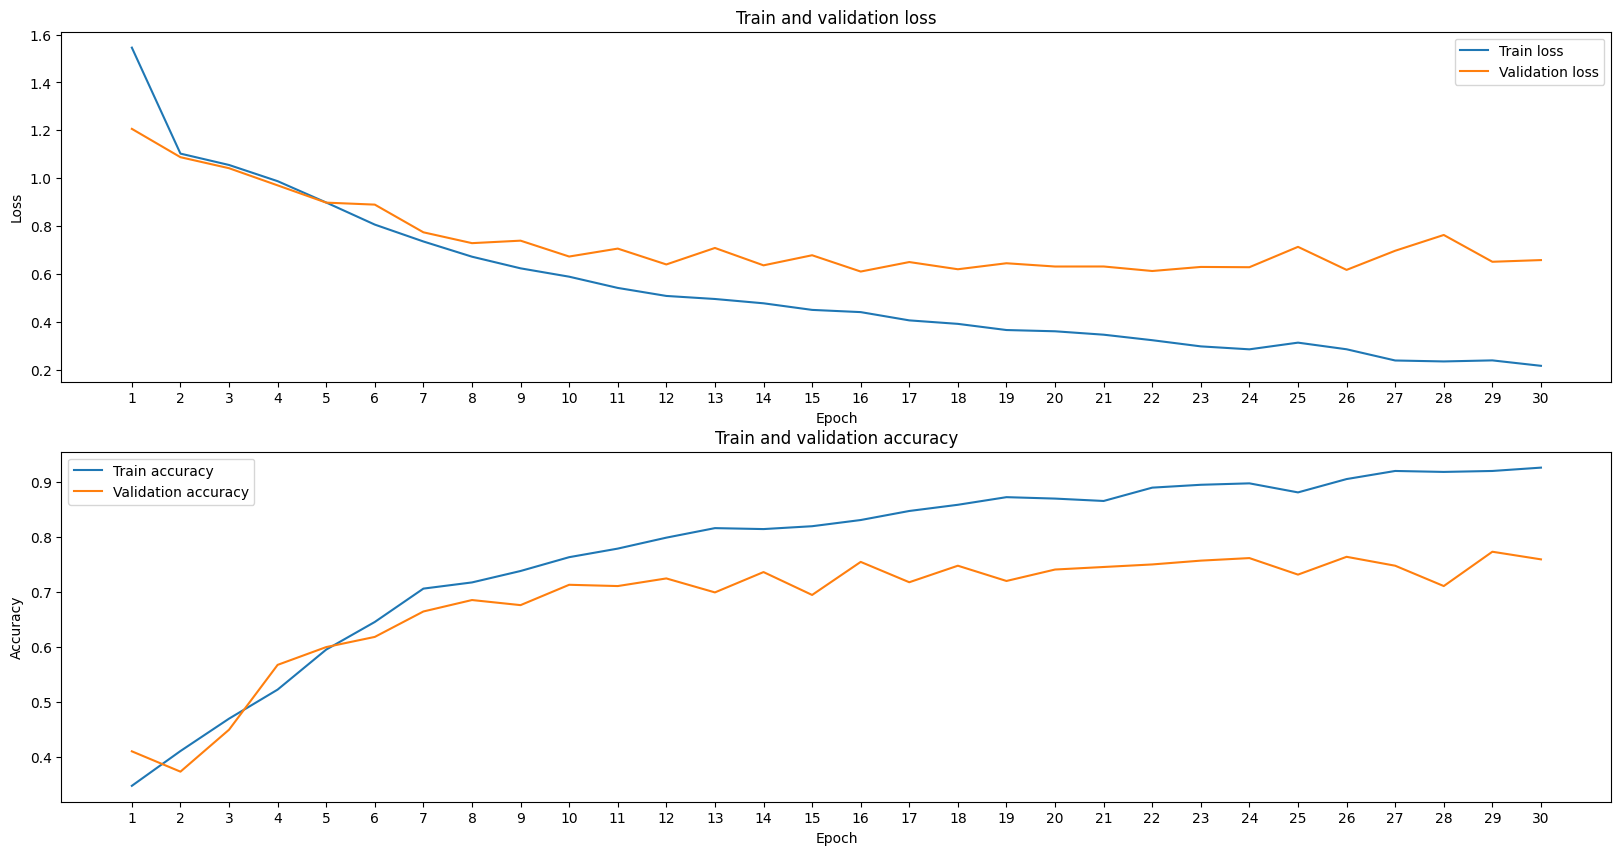

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20,10))
ax1.set_title('Train and validation loss')
ax1.plot(array, train_loss, label='Train loss')
ax1.plot(array, val_loss, label = 'Validation loss')
ax2.set_title('Train and validation accuracy')
ax2.plot(array, train_accuracy, label='Train accuracy')
ax2.plot(array, val_accuracy, label = 'Validation accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
ax1.set_xticks(array)
ax2.set_xticks(array)

# **5. Neural network with augumentation and dropout**

In [21]:
model2 = Sequential()
model2.add(layers.Rescaling(1./255))

model2.add(layers.Conv2D(64, (1,1), padding='same', activation='relu'))
model2.add(layers.MaxPool2D((2,2)))
model2.add(layers.Rescaling(scale=4, offset=0.0))

model2.add(layers.Conv2D(32, (1,1), padding='same', activation='relu'))
model2.add(layers.MaxPool2D((2,2)))
model2.add(layers.Dropout(rate=0.1))

model2.add(layers.Flatten())
model2.add(layers.Dense(3, activation='softmax'))

In [22]:
model2.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [23]:
history2 = model2.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 30,
    batch_size = batch_size)

Epoch 1/30
12/12 [==============================] - 4s 150ms/step - loss: 2.2313 - accuracy: 0.3226 - val_loss: 1.4622 - val_accuracy: 0.4074
Epoch 2/30
12/12 [==============================] - 2s 128ms/step - loss: 1.3309 - accuracy: 0.3816 - val_loss: 1.0895 - val_accuracy: 0.3194
Epoch 3/30
12/12 [==============================] - 3s 189ms/step - loss: 1.0588 - accuracy: 0.4423 - val_loss: 1.0503 - val_accuracy: 0.5185
Epoch 4/30
12/12 [==============================] - 3s 136ms/step - loss: 0.9742 - accuracy: 0.5620 - val_loss: 0.9293 - val_accuracy: 0.5625
Epoch 5/30
12/12 [==============================] - 2s 127ms/step - loss: 0.8471 - accuracy: 0.6227 - val_loss: 0.8325 - val_accuracy: 0.6181
Epoch 6/30
12/12 [==============================] - 3s 143ms/step - loss: 0.7577 - accuracy: 0.6938 - val_loss: 0.7936 - val_accuracy: 0.6597
Epoch 7/30
12/12 [==============================] - 3s 134ms/step - loss: 0.6939 - accuracy: 0.7164 - val_loss: 0.7676 - val_accuracy: 0.6829
Epoch 

# **6. Learning curve - dropout and augumentation**

In [26]:
train_loss2 = history2.history['loss']
train_accuracy2 = history2.history['accuracy']
val_loss2 = history2.history['val_loss']
val_accuracy2 = history2.history['val_accuracy']
array2 = np.arange(1,31,1)

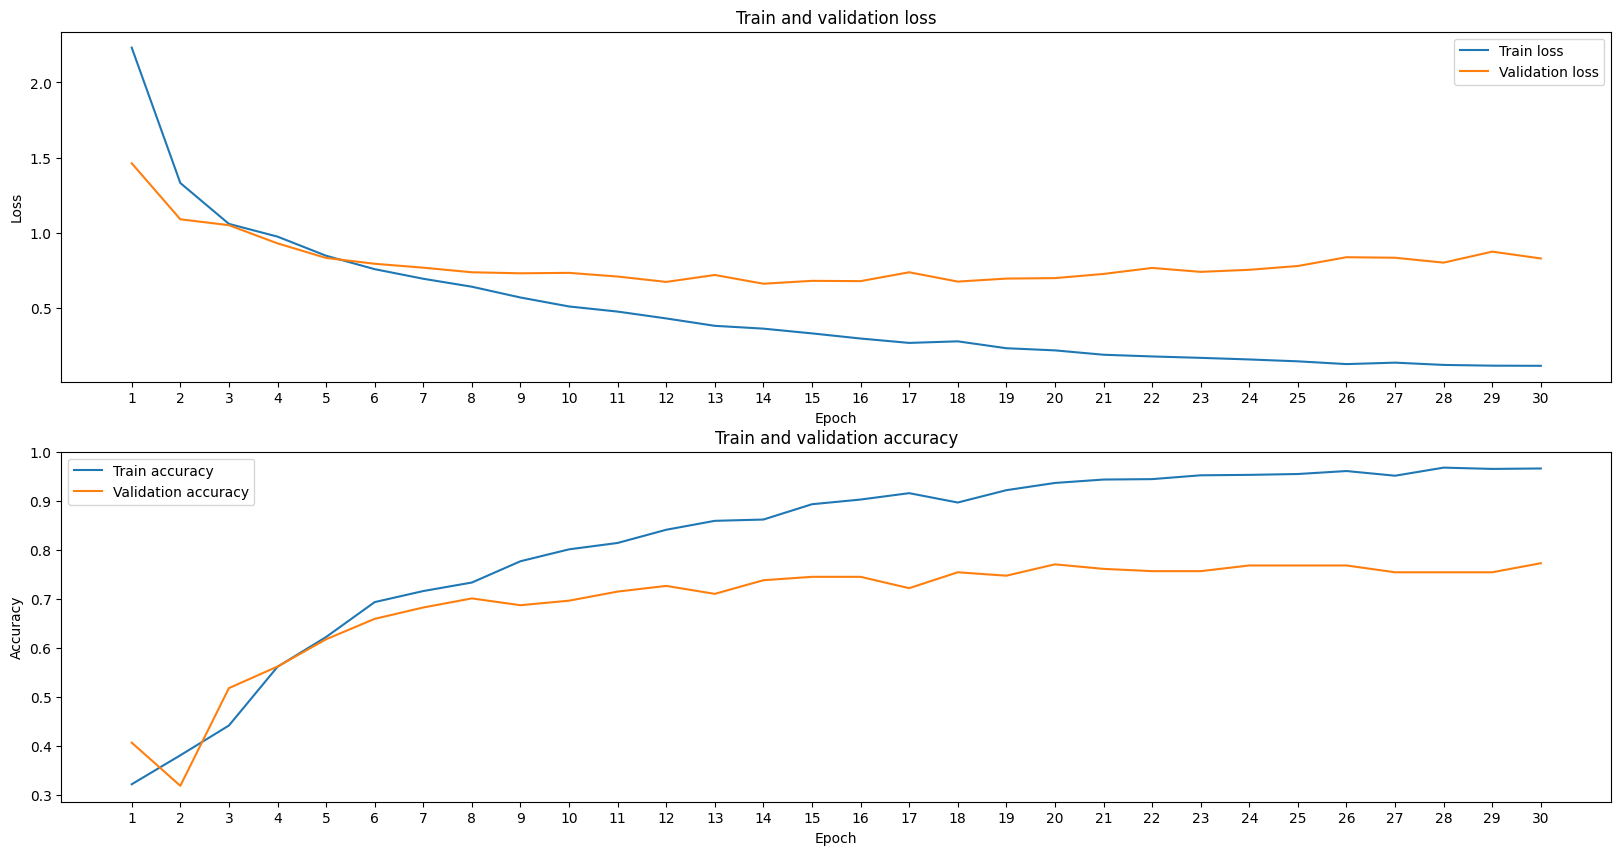

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20,10))
ax1.set_title('Train and validation loss')
ax1.plot(array2, train_loss2, label='Train loss')
ax1.plot(array2, val_loss2, label = 'Validation loss')
ax2.set_title('Train and validation accuracy')
ax2.plot(array2, train_accuracy2, label='Train accuracy')
ax2.plot(array2, val_accuracy2, label = 'Validation accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
ax1.set_xticks(array2)
ax2.set_xticks(array2)